In [1]:
include("../Inversion/Plot.jl")
include("Linear.jl")
include("../Inversion/KalmanInversion.jl")

update_ensemble! (generic function with 4 methods)

# Hilbert Matrix Inversion
Consider the Hilbert matrix inversion problem
$$y = G\theta + \eta   \qquad G_{i,j} = \frac{1}{i+j-1} \qquad \theta_{ref} = 1$$
with $N_{\theta} = 10$ and $\eta \sim \mathcal{N}(0, 0.1^2I)$. 

In [2]:
function Hilbert_Test(N_θ::Int64)
    
    θ0_mean = zeros(Float64, N_θ)  # mean 
    θθ0_cov = Array(Diagonal(fill(0.5^2, N_θ)))     # standard deviation
    
    
    G = zeros(N_θ, N_θ)
    for i = 1:N_θ
        for j = 1:N_θ
            G[i,j] = 1/(i + j - 1)
        end
    end
    
    θ_ref = fill(1.0, N_θ)
    y   = G*θ_ref 
    Σ_η = Array(Diagonal(fill(0.5^2, N_θ)))
    
    return θ_ref, G, y, Σ_η
end

Hilbert_Test (generic function with 1 method)

## Unscented Kalman Inversion


The unscented Kalman inversion is applied with $\theta_0 \sim \mathcal{N}(0, 0.5^2I)$.
For comparison, ensemble Kalman inversion (EKI), and it deterministic variants, 
ensemble adjustment Kalman inversion (EAKI) and ensemble transform Kalman inversion (ETKI) 
are applied with $10N_{\theta} + 1$ ensemble members initially sampled from $\theta_0 \sim \mathcal{N}(0, 0.5^2I)$.
The convergence of the $\theta$ for are depicted, in terms of the $L_2$ error $\lVert m_n - \theta_{ref}\rVert_2$. 
All EKI, EAKI and ETKI suffer from divergence, but UKI comverges with a $\textrm{cond}(G)$ dependent exponential rate.

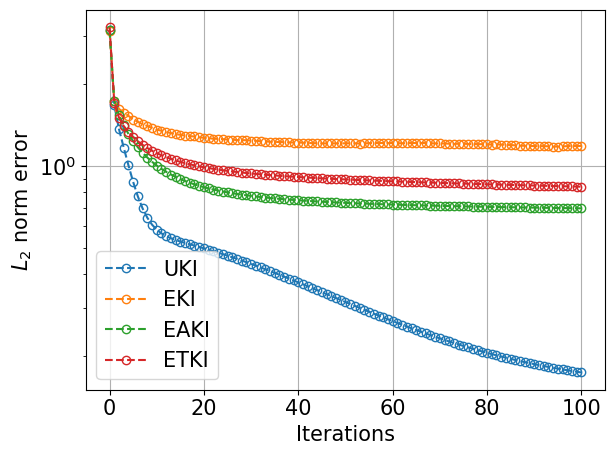

In [3]:
FT = Float64
uki_objs = Dict()


α_reg = 1.0
update_freq = 0
N_iter = 100

N_θ = 10
θ_ref, G, y, Σ_η = Hilbert_Test(N_θ)


N_y = length(y)

s_param = Setup_Param(G, N_θ, N_y)

θ0_mean = zeros(FT, N_θ)
θθ0_cov = Array(Diagonal(fill(0.5^2, N_θ)))
θθ0_cov_sqrt = sqrt.(θθ0_cov)

uki_obj = UKI_Run(s_param, forward, 
θ0_mean, θθ0_cov,
y, Σ_η,
α_reg,
update_freq,
N_iter)


filter_type = "EKI"
N_ens = 10N_θ + 1
eki_obj = EKI_Run(s_param, forward, 
filter_type,
θ0_mean, θθ0_cov_sqrt,
N_ens,
y, Σ_η,
α_reg,
update_freq,
N_iter)

filter_type = "EAKI"
N_ens = 10N_θ + 1
eaki_obj = EKI_Run(s_param, forward, 
filter_type,
θ0_mean, θθ0_cov_sqrt,
N_ens,
y, Σ_η,
α_reg,
update_freq,
N_iter)

filter_type = "ETKI"
N_ens = 10N_θ + 1
etki_obj = EKI_Run(s_param, forward, 
filter_type,
θ0_mean, θθ0_cov_sqrt,
N_ens,
y, Σ_η,
α_reg,
update_freq,
N_iter)

mean_errors = zeros(FT, 4, N_iter+1)
for i = 1:N_iter+1
    mean_errors[1, i] = norm(uki_obj.θ_mean[i] .- θ_ref)
    mean_errors[2, i] = norm(dropdims(mean(eki_obj.θ[i],  dims=1), dims=1)  .- θ_ref)
    mean_errors[3, i] = norm(dropdims(mean(eaki_obj.θ[i], dims=1), dims=1)  .- θ_ref)
    mean_errors[4, i] = norm(dropdims(mean(etki_obj.θ[i], dims=1), dims=1)  .- θ_ref)
end



ites = Array(0:N_iter)
semilogy(ites, mean_errors[1, :], "--o", fillstyle="none", label="UKI")
semilogy(ites, mean_errors[2, :], "--o", fillstyle="none", label="EKI")
semilogy(ites, mean_errors[3, :], "--o", fillstyle="none", label="EAKI")
semilogy(ites, mean_errors[4, :], "--o", fillstyle="none", label="ETKI")
xlabel("Iterations")
ylabel("\$L_2\$ norm error")
grid("on")
legend()
tight_layout()